# ID5059 Group Project - Model Evaluation
 
This notebook evaluates predictions from four different models:
- Gradient Boosting
- Linear Regression
- Neural Network
- Random Forest
 
This file compares their performance by visualizing actual vs. predicted values and calculating metrics.

In [2]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score
import os
import joblib
from datetime import datetime

# set up a consistent plotting style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context("notebook", font_scale=1.2)
plt.rcParams['figure.figsize'] = (12, 8)

### 1. Load and Prepare Data
 
This section loads the prediction files from all 4 models and prepares them for comparison.

In [ ]:
# load Gradient Boosting predictions
try:
    gb_predictions = pd.read_csv('gb_y_valid_predictions.csv')
    print("Gradient Boosting predictions loaded successfully:")
    print(gb_predictions.head())
except Exception as e:
    print(f"Error loading Gradient Boosting predictions: {e}")
    # create dummy data for demonstration
    gb_predictions = pd.DataFrame({
        'actual': np.random.normal(280, 5, 100),
        'prediction': np.random.normal(280, 5, 100)
    })

# load Random Forest predictions
try:
    rf_predictions = pd.read_csv('rf_y_valid_predictions.csv')
    print("\nRandom Forest predictions loaded successfully:")
    print(rf_predictions.head())
except Exception as e:
    print(f"Error loading Random Forest predictions: {e}")
    # create dummy data for demonstration
    rf_predictions = pd.DataFrame({
        'true_t2m': np.random.normal(280, 5, 100),
        'predicted_t2m': np.random.normal(280, 5, 100)
    })

# load Linear Regression predictions (scientific notation format)
try:
    # skip header row if it exists and directly convert to float
    lr_predictions_raw = pd.read_csv('lr_y_valid_predictions.csv', header=None)
    # check if the first row looks like a header
    if isinstance(lr_predictions_raw.iloc[0, 0], str) and 'prediction' in lr_predictions_raw.iloc[0, 0].lower():
        lr_predictions_raw = lr_predictions_raw.iloc[1:, :]
    
    # convert to float (handles scientific notation)
    lr_predictions = pd.DataFrame({
        'prediction': lr_predictions_raw[0].astype(float)
    })
    print("\nLinear Regression predictions loaded successfully:")
    print(lr_predictions.head())
except Exception as e:
    print(f"Error loading Linear Regression predictions: {e}")
    # create dummy data for demonstration
    lr_predictions = pd.DataFrame({
        'prediction': np.random.normal(280, 5, 100)
    })

# load Neural Network predictions (scientific notation format)
try:
    # skip header row if it exists and directly convert to float
    nn_predictions_raw = pd.read_csv('nn_y_valid_predictions.csv', header=None)
    # check if the first row looks like a header
    if isinstance(nn_predictions_raw.iloc[0, 0], str) and 'prediction' in nn_predictions_raw.iloc[0, 0].lower():
        nn_predictions_raw = nn_predictions_raw.iloc[1:, :]
    
    # convert to float (handles scientific notation)
    nn_predictions = pd.DataFrame({
        'prediction': nn_predictions_raw[0].astype(float)
    })
    print("\nNeural Network predictions loaded successfully:")
    print(nn_predictions.head())
except Exception as e:
    print(f"Error loading Neural Network predictions: {e}")
    # create dummy data for demonstration
    nn_predictions = pd.DataFrame({
        'prediction': np.random.normal(280, 5, 100)
    })

# prepare datasets with standardised column names and add actual values where missing
datasets = {}

# add Gradient Boosting data
if 'gb_predictions' in locals():
    datasets['Gradient Boosting'] = {
        'actual': gb_predictions['actual'].values,
        'predicted': gb_predictions['prediction'].values
    }

# add Random Forest data
if 'rf_predictions' in locals():
    datasets['Random Forest'] = {
        'actual': rf_predictions['true_t2m'].values,
        'predicted': rf_predictions['predicted_t2m'].values
    }

# for Linear Regression, add actual values from Gradient Boosting
if 'lr_predictions' in locals():
    # use actual values from gradient boosting if available and sizes match
    if 'gb_predictions' in locals() and len(gb_predictions) == len(lr_predictions):
        actual_values = gb_predictions['actual'].values
    else:
        # otherwise use RF if sizes match
        actual_values = rf_predictions['true_t2m'].values if len(rf_predictions) == len(lr_predictions) else None
    
    # if we have actual values, create the dataset
    if actual_values is not None:
        datasets['Linear Regression'] = {
            'actual': actual_values[:len(lr_predictions)],
            'predicted': lr_predictions['prediction'].values
        }
    else:
        print("Warning: Could not find matching actual values for Linear Regression")

# for Neural Network, add actual values from Gradient Boosting
if 'nn_predictions' in locals():
    # use actual values from gradient boosting if available and sizes match
    if 'gb_predictions' in locals() and len(gb_predictions) == len(nn_predictions):
        actual_values = gb_predictions['actual'].values
    else:
        # otherwise use RF if sizes match
        actual_values = rf_predictions['true_t2m'].values if len(rf_predictions) == len(nn_predictions) else None
    
    # if we have actual values, create the dataset
    if actual_values is not None:
        datasets['Neural Network'] = {
            'actual': actual_values[:len(nn_predictions)],
            'predicted': nn_predictions['prediction'].values
        }
    else:
        print("Warning: Could not find matching actual values for Neural Network")

Gradient Boosting predictions loaded successfully:
      actual  prediction
0  283.53760  282.946940
1  283.28590  282.081144
2  274.53480  274.573258
3  288.54736  287.853762
4  273.70874  273.633076

Random Forest predictions loaded successfully:
    true_t2m  predicted_t2m
0  277.47583     277.765429
1  283.66638     283.870148
2  281.45703     278.927559
3  282.55933     282.544864
4  276.51587     277.078198


C:\Users\Egor Ubiytsia\AppData\Local\Temp\ipykernel_28252\3065788017.py:30: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  lr_predictions_raw = pd.read_csv('lr_y_valid_predictions.csv', header=None)



Linear Regression predictions loaded successfully:
   prediction
1  284.948368
2  281.829191
3  275.072167
4  287.529951
5  273.610557


C:\Users\Egor Ubiytsia\AppData\Local\Temp\ipykernel_28252\3065788017.py:51: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  nn_predictions_raw = pd.read_csv('nn_y_valid_predictions.csv', header=None)



Neural Network predictions loaded successfully:
   prediction
1  284.331024
2  282.524658
3  273.568481
4  285.327515
5  272.738739


### 2. Individual Model Evaluation Plots
 
This section creates a scatter plot for each model showing actual vs. predicted values.

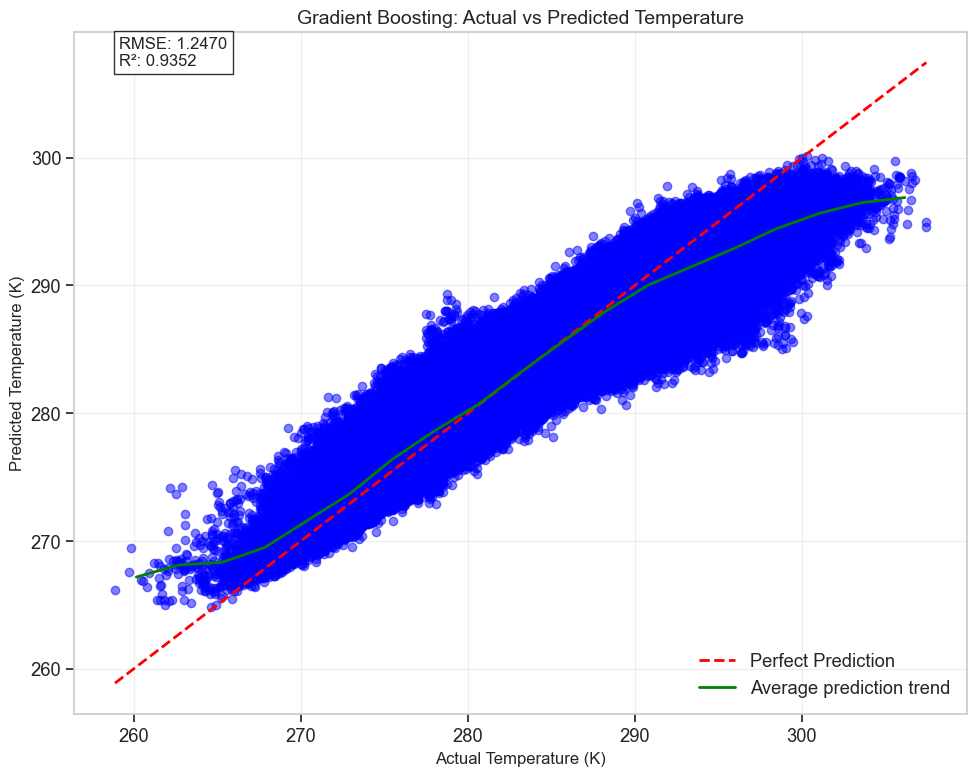

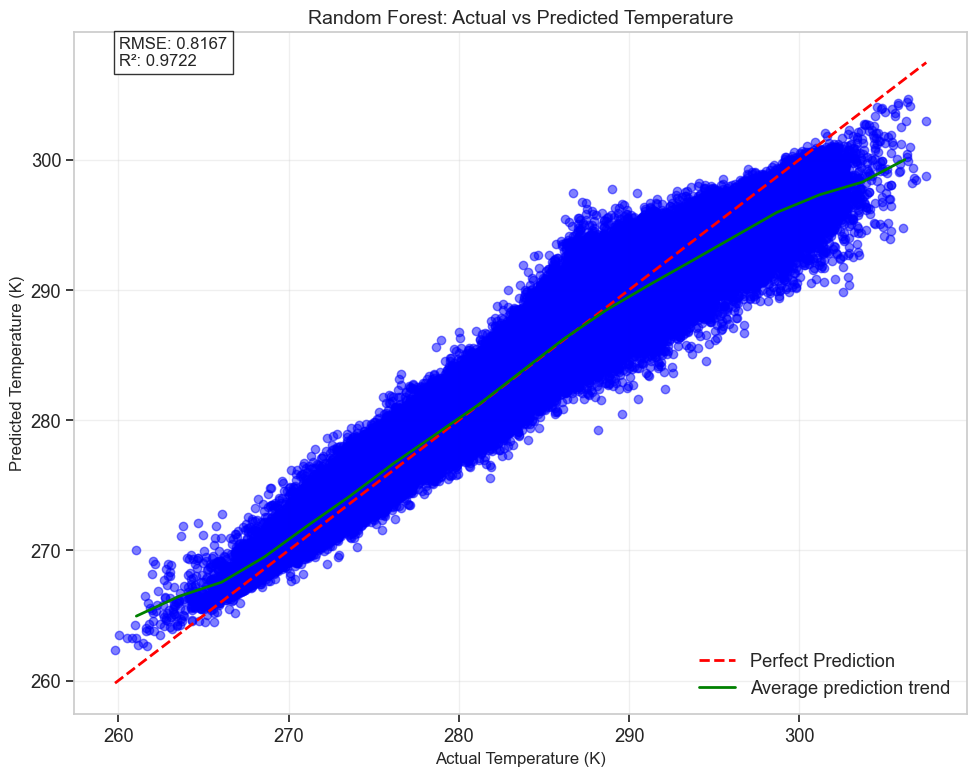

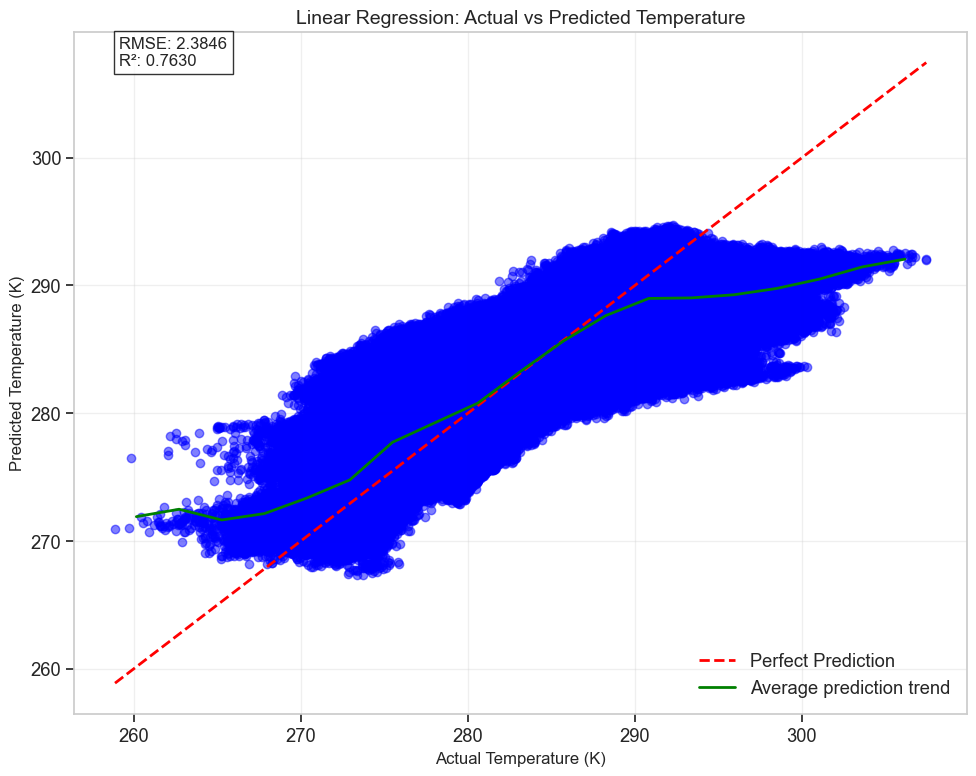

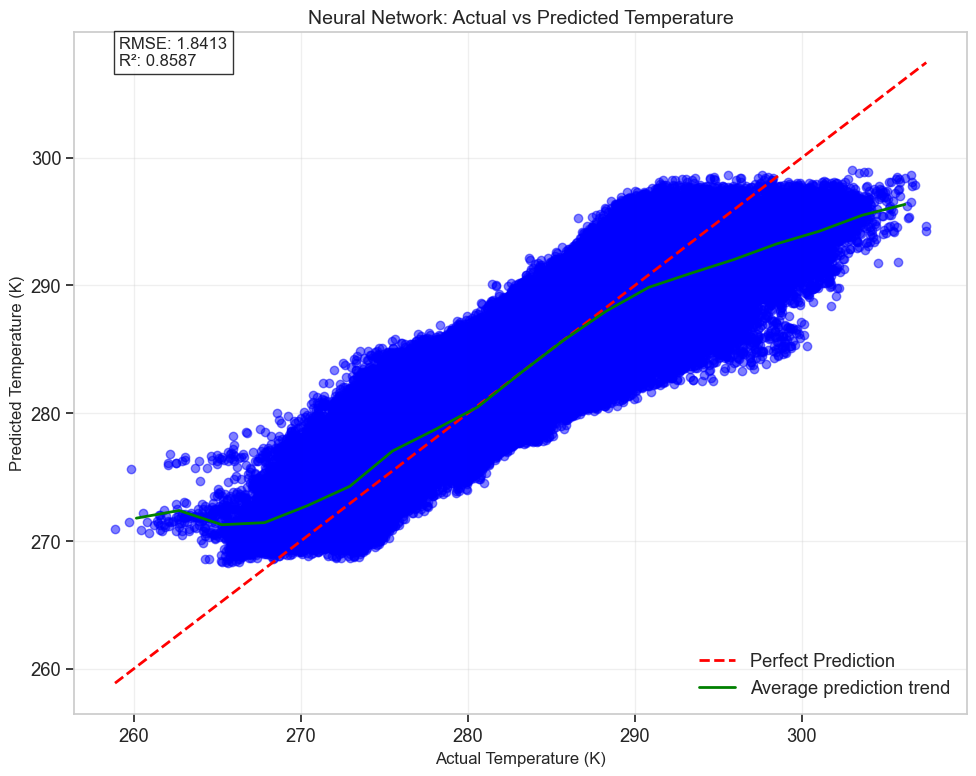

In [ ]:
# this is a function to create individual model plots
def create_model_plot(actual, predicted, model_name):
    fig = plt.figure(figsize=(10, 8))
    
    # calculate metrics
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    r2 = r2_score(actual, predicted)
    
    # create scatter plot
    plt.scatter(actual, predicted, alpha=0.5, color='blue')
    
    # add perfect prediction line
    min_val = min(actual.min(), predicted.min())
    max_val = max(actual.max(), predicted.max())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect Prediction')
    
    # add a trend line to show actual model behavior
    from scipy.stats import binned_statistic
    bins = np.linspace(actual.min(), actual.max(), 20)
    bin_means, bin_edges, _ = binned_statistic(actual, predicted, statistic='mean', bins=bins)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    plt.plot(bin_centers, bin_means, 'g-', lw=2, label='Average prediction trend')
    
    # add metrics as text
    plt.text(0.05, 0.95, f"RMSE: {rmse:.4f}\nR²: {r2:.4f}", 
             transform=plt.gca().transAxes, fontsize=12, 
             bbox=dict(facecolor='white', alpha=0.8))
    
    # labels and title
    plt.xlabel('Actual Temperature (K)', fontsize=12)
    plt.ylabel('Predicted Temperature (K)', fontsize=12)
    plt.title(f'{model_name}: Actual vs Predicted Temperature', fontsize=14)
    plt.legend(loc='lower right')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    
    return fig, rmse, r2

# create individual plots and store metrics
metrics = {}

for model_name, data in datasets.items():
    fig, rmse, r2 = create_model_plot(data['actual'], data['predicted'], model_name)
    metrics[model_name] = {'RMSE': rmse, 'R²': r2}
    plt.show()

### 3. Combined Comparison Plot
 
This section creates a single plot that shows all models together for direct comparison.

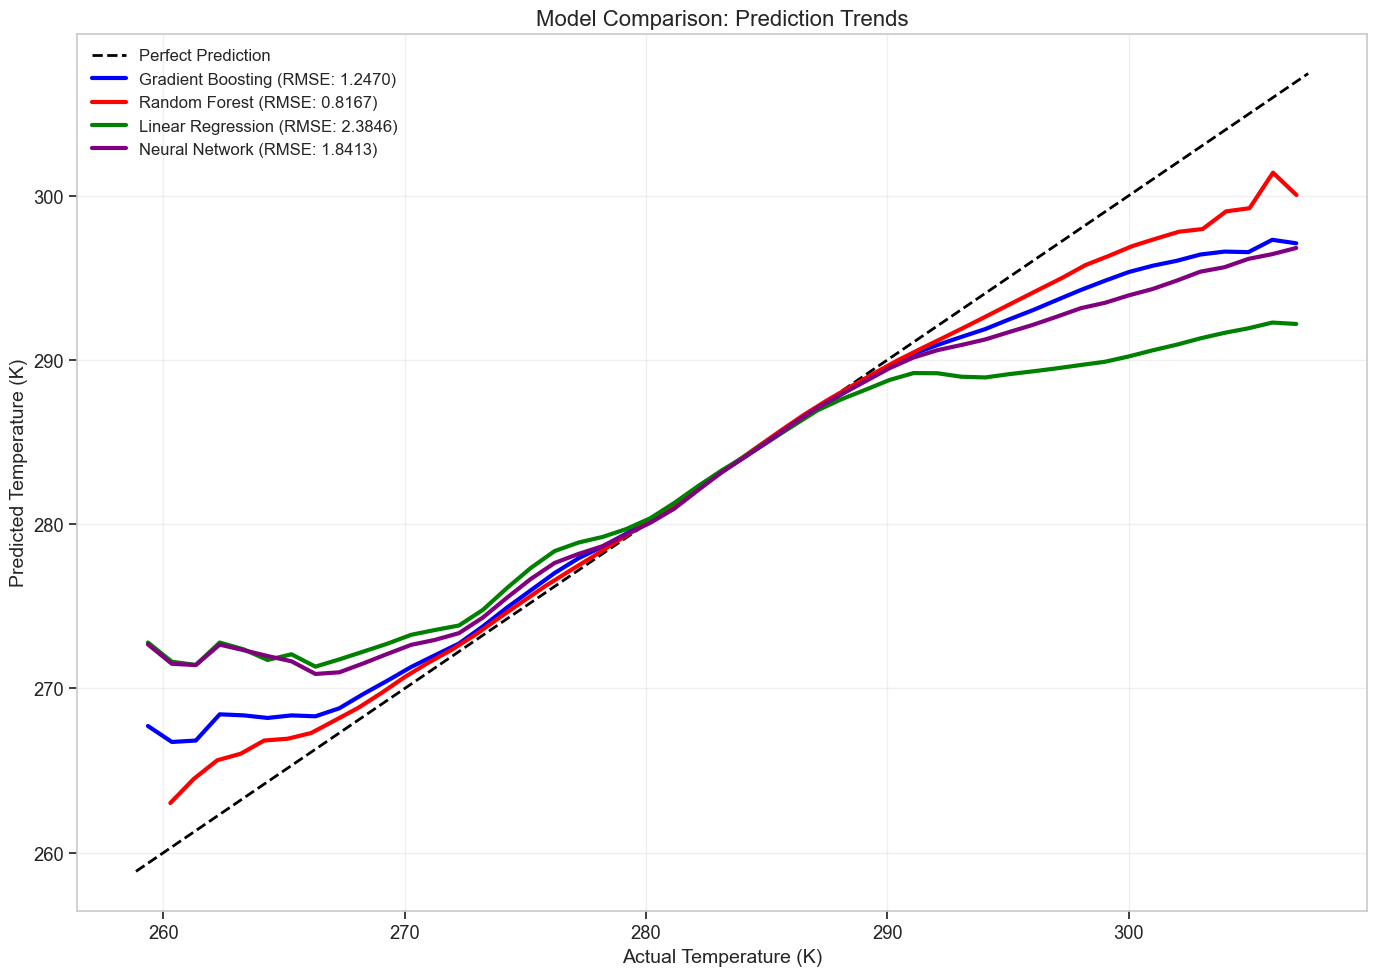

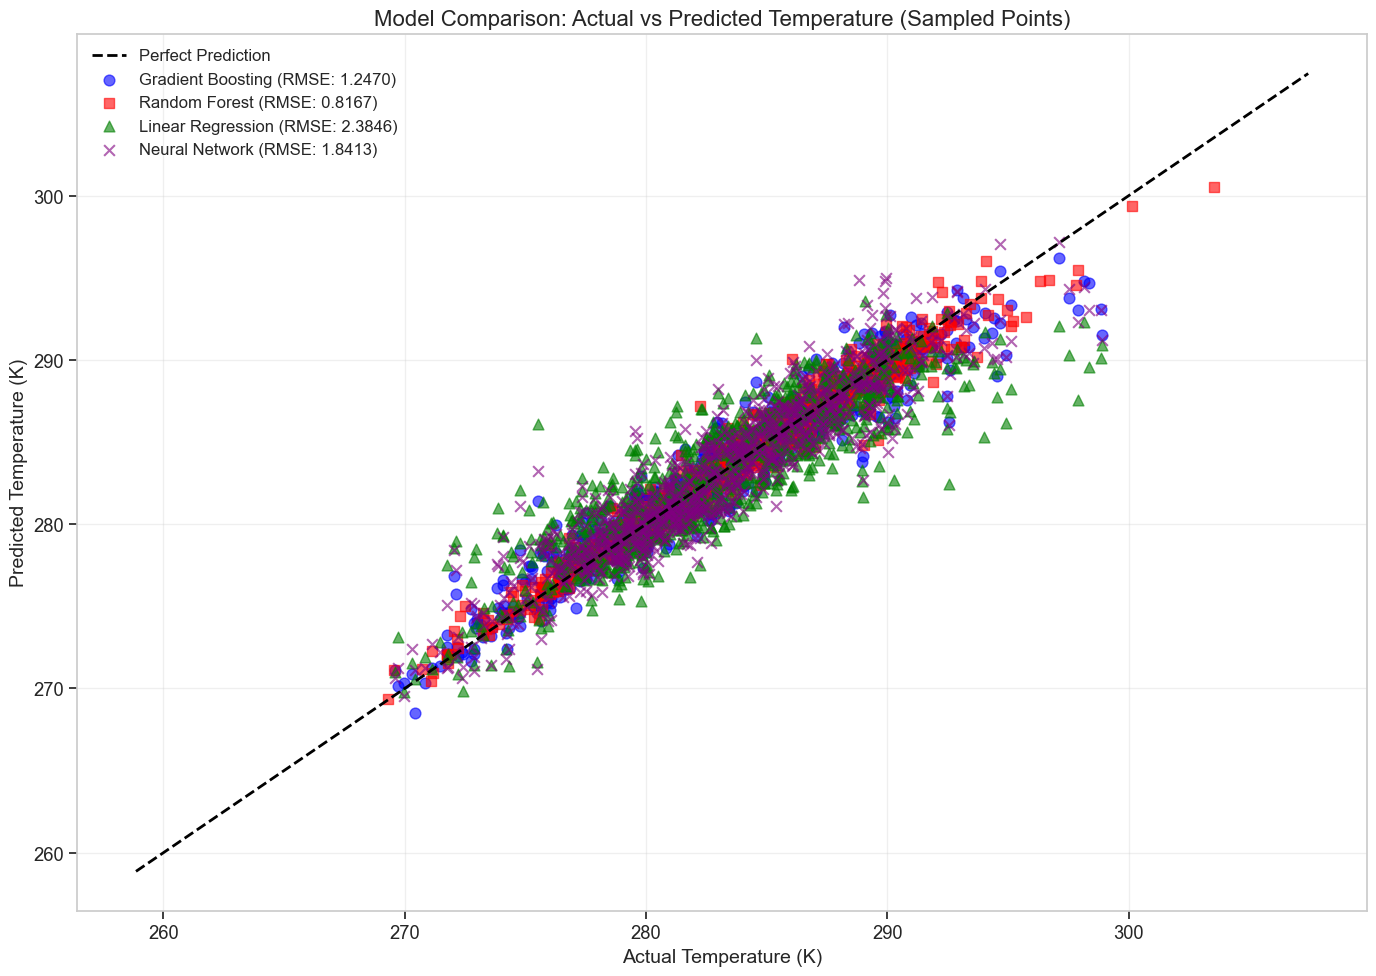

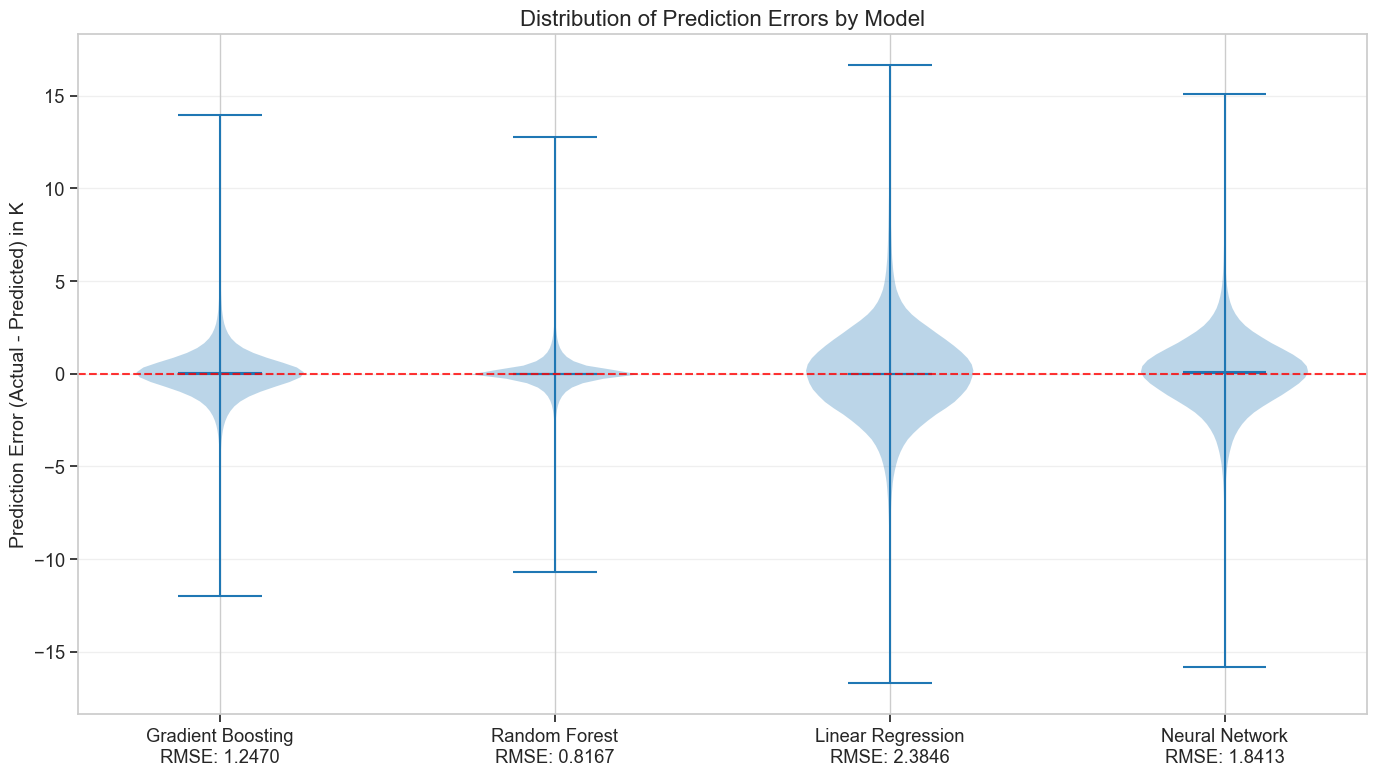

In [ ]:
# trend lines graph
plt.figure(figsize=(14, 10))

# define colors for each model
colors = ['blue', 'red', 'green', 'purple']

# add perfect prediction line
all_min = min([np.min(data['actual']) for data in datasets.values()])
all_max = max([np.max(data['actual']) for data in datasets.values()])
plt.plot([all_min, all_max], [all_min, all_max], 'k--', linewidth=2, label='Perfect Prediction')

# for each model, create a smoothed trend line instead of scatter points
for i, (model_name, data) in enumerate(datasets.items()):
    # create a smoothed trend line using binned statistics
    from scipy.stats import binned_statistic
    bins = np.linspace(np.min(data['actual']), np.max(data['actual']), 50)
    bin_means, bin_edges, _ = binned_statistic(data['actual'], data['predicted'], statistic='mean', bins=bins)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    
    # plot the trend line with higher line width for visibility
    plt.plot(bin_centers, bin_means, '-', color=colors[i % len(colors)], 
             linewidth=3, label=f"{model_name} (RMSE: {metrics[model_name]['RMSE']:.4f})")

# labels and title
plt.xlabel('Actual Temperature (K)', fontsize=14)
plt.ylabel('Predicted Temperature (K)', fontsize=14)
plt.title('Model Comparison: Prediction Trends', fontsize=16)
plt.legend(loc='upper left', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# sample of points graph for clarity
plt.figure(figsize=(14, 10))

# define colors and markers for each model
colors = ['blue', 'red', 'green', 'purple']
markers = ['o', 's', '^', 'x']

# add perfect prediction line
all_min = min([np.min(data['actual']) for data in datasets.values()])
all_max = max([np.max(data['actual']) for data in datasets.values()])
plt.plot([all_min, all_max], [all_min, all_max], 'k--', linewidth=2, label='Perfect Prediction')

# Plot each model with a different color and marker, but sample points to reduce overlap
for i, (model_name, data) in enumerate(datasets.items()):
    # Sample only 5% of points for clarity
    sample_size = min(1000, int(len(data['actual']) * 0.05))
    np.random.seed(42)  # For reproducibility
    indices = np.random.choice(len(data['actual']), sample_size, replace=False)
    
    # Actual vs predicted (using sampled points)
    plt.scatter(data['actual'][indices], data['predicted'][indices], 
                alpha=0.6,  # Higher alpha since fewer points
                label=f"{model_name} (RMSE: {metrics[model_name]['RMSE']:.4f})",
                color=colors[i % len(colors)],
                marker=markers[i % len(markers)],
                s=60)  # Slightly larger points

# labels and title
plt.xlabel('Actual Temperature (K)', fontsize=14)
plt.ylabel('Predicted Temperature (K)', fontsize=14)
plt.title('Model Comparison: Actual vs Predicted Temperature (Sampled Points)', fontsize=16)
plt.legend(loc='upper left', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# error distribution graph
plt.figure(figsize=(14, 8))

# create box plots of prediction errors
error_data = []
labels = []

for model_name, data in datasets.items():
    # calculate errors (residuals)
    errors = data['actual'] - data['predicted']
    error_data.append(errors)
    labels.append(f"{model_name}\nRMSE: {metrics[model_name]['RMSE']:.4f}")

# create violin plot of errors
plt.violinplot(error_data, showmeans=True, showmedians=True)
plt.axhline(y=0, color='r', linestyle='--', alpha=0.8, label='Zero Error')

# set x-tick labels
plt.xticks(np.arange(1, len(labels) + 1), labels)
plt.ylabel('Prediction Error (Actual - Predicted) in K', fontsize=14)
plt.title('Distribution of Prediction Errors by Model', fontsize=16)
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

### 4. Performance Metrics Comparison
 
This section creates a simple comparison of RMSE, MAE and R² metrics for all models.

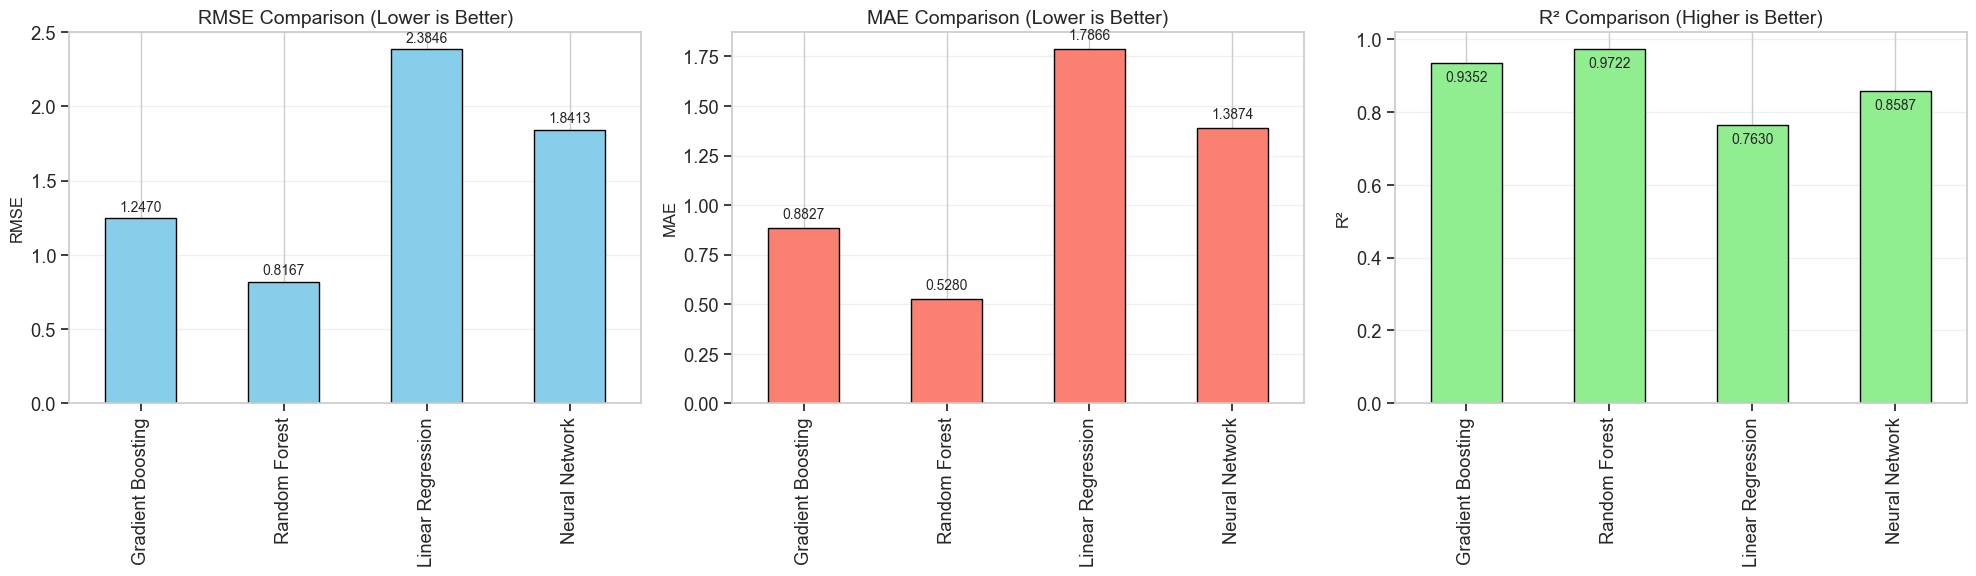

In [ ]:
# create a DataFrame with metrics
metrics_df = pd.DataFrame.from_dict(metrics, orient='index')

# if MAE isn't already calculated, add it
if 'MAE' not in metrics_df.columns:
    for model_name, data in datasets.items():
        metrics_df.loc[model_name, 'MAE'] = np.mean(np.abs(data['actual'] - data['predicted']))

# create bar charts for RMSE, MAE, and R²
fig, ax = plt.subplots(1, 3, figsize=(20, 6))

# RMSE (lower is better)
metrics_df['RMSE'].plot(kind='bar', ax=ax[0], color='skyblue', edgecolor='black')
ax[0].set_title('RMSE Comparison (Lower is Better)', fontsize=14)
ax[0].set_ylabel('RMSE', fontsize=12)
ax[0].grid(axis='y', alpha=0.3)
for i, v in enumerate(metrics_df['RMSE']):
    ax[0].text(i, v + 0.05, f'{v:.4f}', ha='center', fontsize=10)

# MAE (lower is better)
metrics_df['MAE'].plot(kind='bar', ax=ax[1], color='salmon', edgecolor='black')
ax[1].set_title('MAE Comparison (Lower is Better)', fontsize=14)
ax[1].set_ylabel('MAE', fontsize=12)
ax[1].grid(axis='y', alpha=0.3)
for i, v in enumerate(metrics_df['MAE']):
    ax[1].text(i, v + 0.05, f'{v:.4f}', ha='center', fontsize=10)

# R² (higher is better)
metrics_df['R²'].plot(kind='bar', ax=ax[2], color='lightgreen', edgecolor='black')
ax[2].set_title('R² Comparison (Higher is Better)', fontsize=14)
ax[2].set_ylabel('R²', fontsize=12)
ax[2].grid(axis='y', alpha=0.3)
for i, v in enumerate(metrics_df['R²']):
    ax[2].text(i, v - 0.05, f'{v:.4f}', ha='center', fontsize=10)

plt.tight_layout()
plt.show()

### 5. Generate Final Predictions
 
This section loads the best model (Random Forest) and generates predictions for the test dataset.


In [ ]:
# configure for GPU if available (depends on your RF implementation)
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'  # use first GPU

# load random forest model
try:
    print("Loading Random Forest model...")
    best_model = joblib.load('rf_final_model.pkl')
    print("Model loaded successfully!")
except Exception as e:
    print(f"Error loading model: {e}")
    raise

# load processed test dataset
try:
    print("Loading test dataset...")
    test_data = pd.read_csv('processed_test_with_nearby_features.csv')
    print(f"Test data loaded successfully with shape: {test_data.shape}")
    print(f"Test data columns: {test_data.columns.tolist()}")
except Exception as e:
    print(f"Error loading test data: {e}")
    raise

# define same feature sets used during training
standard_features = [
    'tp', 'sp', 'u10', 'v10', 'u100', 'v100', 'tcc', 'ptype',
    'month', 'day', 'hour', 'season'
]
lag_vars = ['tp', 'sp', 'u10', 'v10']
spatial_vars = ['tp', 'sp', 'tcc']

# define lag and spatial lag features
lag_features = [f'{var}_lag1' for var in lag_vars]
spatial_lag_features = [f'{var}_lag1_spatial_mean' for var in lag_vars]

# keep only features used during training - used for correct model use 
model_features = standard_features + lag_features + spatial_vars + spatial_lag_features

# check if all features are present in test data
missing_features = [f for f in model_features if f not in test_data.columns]
if missing_features:
    raise ValueError(f"Missing features in test data: {missing_features}")

# create a copy of the test data with only the required features
test_data_for_model = test_data[model_features].copy()

# display a sample of the prepared test data
print("Sample of prepared test data:")
print(test_data_for_model.head())

# reconstruct valid_time from year, month, day, hour
print("Reconstructing valid_time from components...")

# create valid_time using datetime
try:
    # create a list of datetime objects
    valid_times = []
    for _, row in test_data.iterrows():
        valid_times.append(
            datetime(
                year=2019,  # year apended to each row
                month=int(row['month']),
                day=int(row['day']),
                hour=int(row['hour'])
            )
        )
    
    # add valid_time to the dataframe
    test_data['valid_time'] = valid_times
    print("Successfully reconstructed valid_time")
except Exception as e:
    print(f"Error reconstructing valid_time: {e}")
    raise

# generate predictions using model
print("Generating predictions...")
try:
    # make predictions using only features that model was trained on
    print(f"Using {len(model_features)} features for prediction")
    
    # make predictions
    predictions = best_model.predict(test_data_for_model)
    print(f"Generated {len(predictions)} predictions")
    
    # display a few predictions
    print("Sample predictions:", predictions[:5])
except Exception as e:
    print(f"Error making predictions: {e}")
    raise

# create a DataFrame with valid_time and prediction
try:
    predictions_df = pd.DataFrame({
        'valid_time': test_data['valid_time'],
        'prediction': predictions
    })
    
    # display a few rows
    print("Predictions DataFrame:")
    print(predictions_df.head())
        
    # save to CSV
    predictions_df.to_csv('predictions.csv', index=False)
    print("Predictions saved to 'predictions.csv'")
    
    # display the file info
    file_size = os.path.getsize('predictions.csv') / 1024  # size in KB
    print(f"File size: {file_size:.2f} KB")
    print(f"Number of rows: {len(predictions_df)}")
except Exception as e:
    print(f"Error saving predictions: {e}")
    raise

Loading Random Forest model...
Model loaded successfully!
Loading test dataset...
Test data loaded successfully with shape: (13288920, 23)
Test data columns: ['tp', 'sp', 'u10', 'v10', 'u100', 'v100', 'tcc', 'ptype', 'month', 'day', 'hour', 'season', 'tp_lag1', 'sp_lag1', 'u10_lag1', 'v10_lag1', 'tp.1', 'sp.1', 'tcc.1', 'tp_lag1_spatial_mean', 'sp_lag1_spatial_mean', 'u10_lag1_spatial_mean', 'v10_lag1_spatial_mean']
Sample of prepared test data:
         tp          sp       u10       v10      u100      v100       tcc  \
0  0.000031  103730.125 -0.363403  1.564896  0.013824  2.183533  1.000000   
1  0.000025  103751.190 -0.715088  0.993683 -0.346558  1.472794  0.991821   
2  0.000022  103743.560 -1.237763  0.827515 -0.934402  1.199982  1.000000   
3  0.000027  103723.875 -1.459732  1.083801 -1.245773  1.366211  0.989807   
4  0.000040  103747.060 -1.407913  1.368607 -1.292343  1.589783  0.996002   

   ptype  month  day  ...     sp_lag1  u10_lag1  v10_lag1        tp  \
0    1.0      1 